In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from hub_tools import *
from astropy.coordinates import SkyCoord
from astropy import units as u

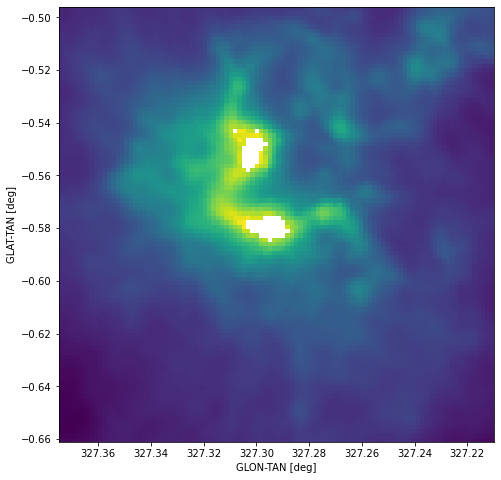

,Seq,Name,RAJ2000,DEJ2000,amaj,amin,PA,FWHM,Sp,Sint,S_N
0,916,G327.2921-0.5792,238.2851,-54.6191,25,22,0,23,49.21,71.17,243.25
1,918,G327.2970-0.5440,238.2530,-54.5888,29,19,144,24,2.35,3.53,19.67
2,919,G327.3005-0.5509,238.2653,-54.5919,38,28,63,33,11.26,32.27,88.00
3,920,G327.3039-0.5775,238.2989,-54.6104,50,22,147,33,7.14,21.32,58.15
4,922,G327.3062-0.5422,238.2633,-54.5816,32,31,14,31,3.51,9.43,33.92
5,923,G327.3087-0.5596,238.2857,-54.5935,24,20,101,22,1.96,2.55,17.33
6,924,G327.3104-0.5503,238.2778,-54.5852,32,19,76,25,0.83,1.39,9.02
7,925,G327.3119-0.5727,238.3044,-54.6016,30,20,100,24,1.20,1.91,12.58


In [2]:
%matplotlib inline

path = '../../IAstro2/'

info = 'sat21sources.fits'
file = 'SAT250_21.fits'

image = fits.open(path+file)[0].data
table = fits.open(path+info)[1].data
tab_head = fits.open(path+info)[1].header

grid,data,sat = display_fits(path+file,return_vals=True)
xl,xr,yb,yt = grid[0][0,0], grid[0][0,-1], grid[1][0,0], grid[1][-1,0]

df = pd.DataFrame(table)
df

In [3]:
#using astropy converter

df['l'] = np.empty(8)
df['b'] = np.empty(8)

names = df['Name'].copy()

for i in range(len(names)):
    df.iloc[i,-2] = float(names[i][1:9])
    df.iloc[i,-1] = float(names[i][9:])

mu_vals = np.array(df.iloc[:,-2:],float)
theta_vals = np.array(df['PA'],float)
FWHM_vals = np.array(df.iloc[:,4:6],float)

df

,Seq,Name,RAJ2000,DEJ2000,amaj,amin,PA,FWHM,Sp,Sint,S_N,l,b
0,916,G327.2921-0.5792,238.2851,-54.6191,25,22,0,23,49.21,71.17,243.25,327.2921,-0.5792
1,918,G327.2970-0.5440,238.2530,-54.5888,29,19,144,24,2.35,3.53,19.67,327.2970,-0.5440
2,919,G327.3005-0.5509,238.2653,-54.5919,38,28,63,33,11.26,32.27,88.00,327.3005,-0.5509
3,920,G327.3039-0.5775,238.2989,-54.6104,50,22,147,33,7.14,21.32,58.15,327.3039,-0.5775
4,922,G327.3062-0.5422,238.2633,-54.5816,32,31,14,31,3.51,9.43,33.92,327.3062,-0.5422
5,923,G327.3087-0.5596,238.2857,-54.5935,24,20,101,22,1.96,2.55,17.33,327.3087,-0.5596
6,924,G327.3104-0.5503,238.2778,-54.5852,32,19,76,25,0.83,1.39,9.02,327.3104,-0.5503
7,925,G327.3119-0.5727,238.3044,-54.6016,30,20,100,24,1.20,1.91,12.58,327.3119,-0.5727


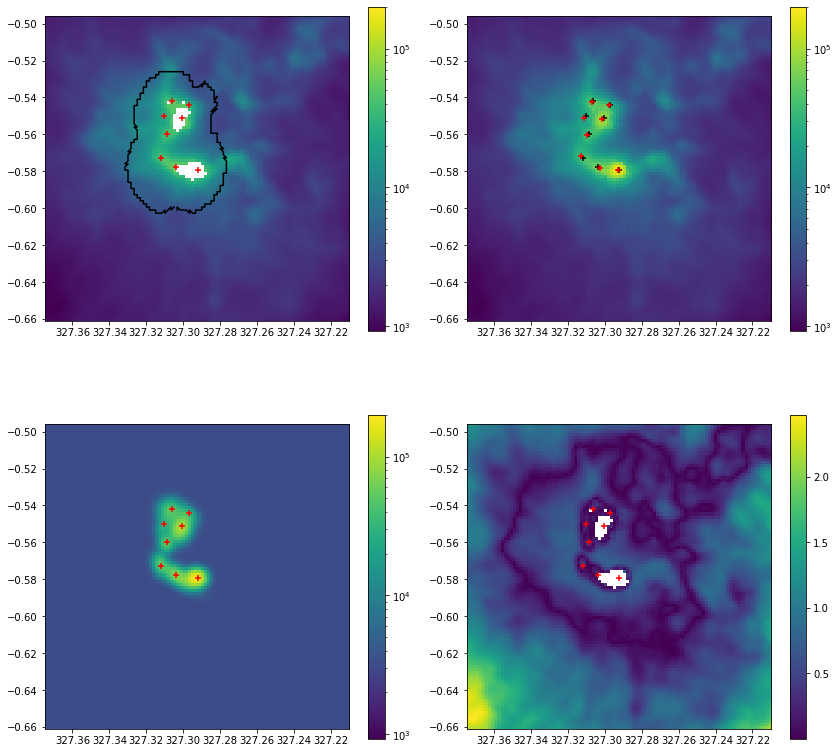

In [4]:
%matplotlib inline
from matplotlib.colors import Normalize,LogNorm

params,image,bg,edge = fitter(grid,data,peaks=8,mu=mu_vals,theta=theta_vals,FWHM=FWHM_vals,fitting_radius=2,bg_method='hist',var_pos=0.001)
gaussians = gaussianMult(grid,*params) + bg
residuals = np.nan*np.ones(data.shape,float)
residuals[~np.isnan(data)] = np.abs(data[~np.isnan(data)]-gaussians[~np.isnan(data)])/data[~np.isnan(data)]

vmin,vmax = image.min(),image.max()
lin_norm = Normalize(vmin,vmax)
log_norm = LogNorm(vmin,vmax)

fig,[[ax0,ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(12,12))

im0 = ax0.imshow(data,origin='lower',extent=[xl,xr,yb,yt],norm=log_norm)
ax0.scatter(mu_vals[:,0],mu_vals[:,1],color='red',marker='+')
ax0.plot(edge[:,0],edge[:,1],color='k')

im1 = ax1.imshow(image,origin='lower',extent=[xl,xr,yb,yt],norm=log_norm)
ax1.scatter(mu_vals[:,0],mu_vals[:,1],color='black',marker='+')
ax1.scatter(params[::6],params[1::6],color='red',marker='+')

im2 = ax2.imshow(gaussians,origin='lower',extent=[xl,xr,yb,yt],norm=log_norm)
ax2.scatter(mu_vals[:,0],mu_vals[:,1],color='red',marker='+')

im3 = ax3.imshow(residuals,origin='lower',extent=[xl,xr,yb,yt])
ax3.scatter(mu_vals[:,0],mu_vals[:,1],color='red',marker='+')

plt.colorbar(im0,ax=ax0,shrink=0.75)
plt.colorbar(im1,ax=ax1,shrink=0.75)
plt.colorbar(im2,ax=ax2,shrink=0.75)
plt.colorbar(im3,ax=ax3,shrink=0.75)

fig.tight_layout(pad=1.2)

plt.show()

<IPython.core.display.Javascript object>


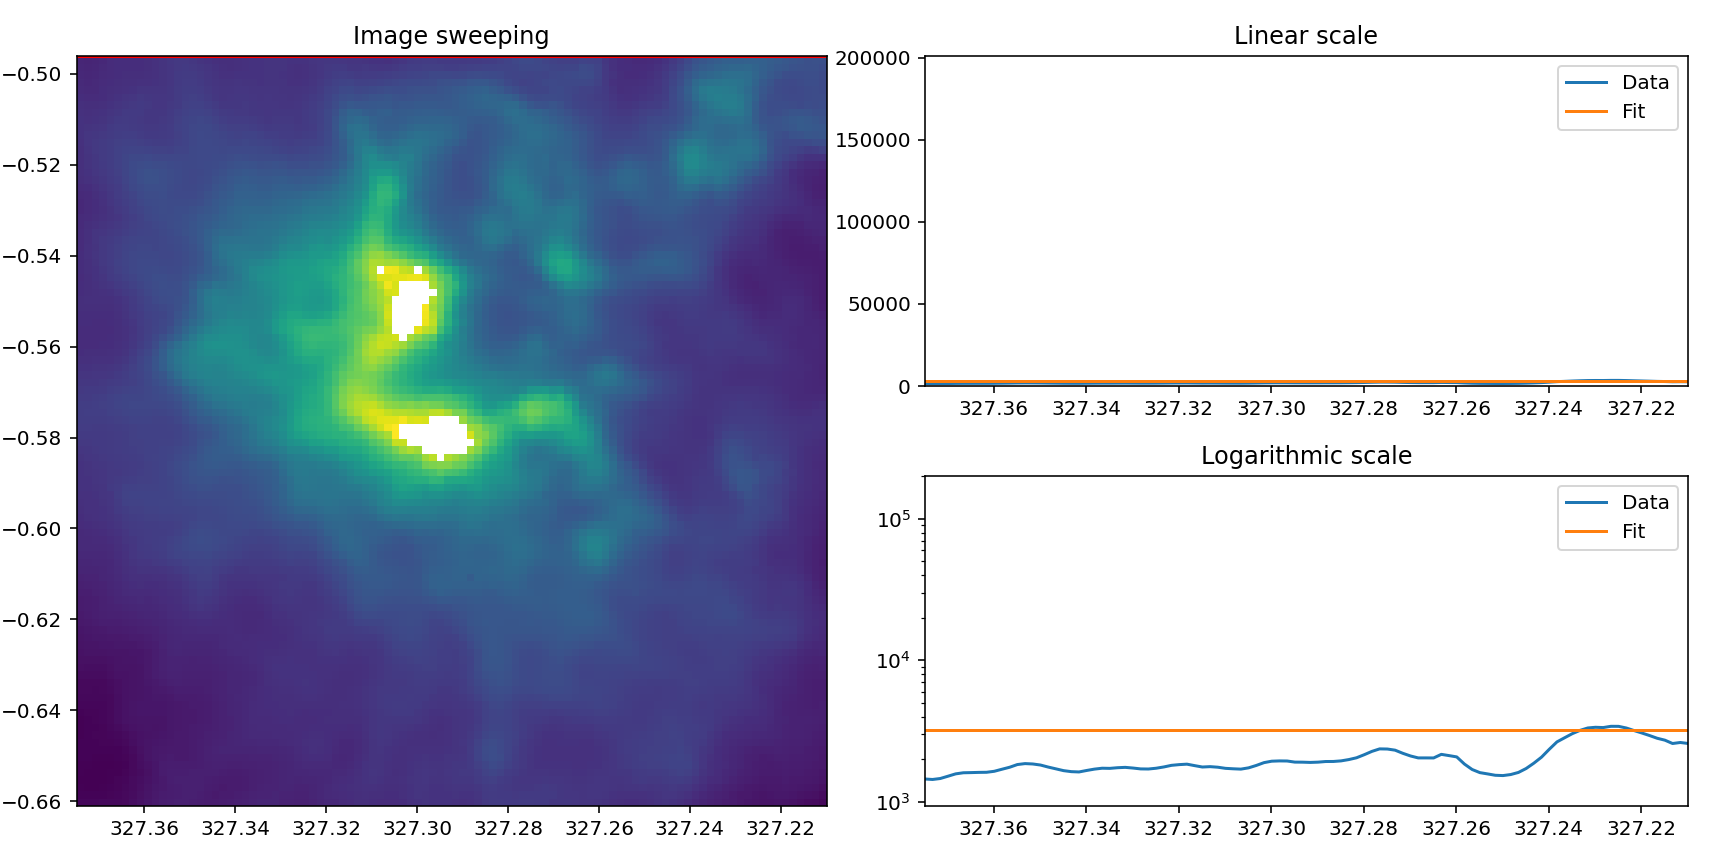

In [5]:
# Image sweeping to see fit explicitly

%matplotlib notebook
from matplotlib.animation import FuncAnimation

X,Y = grid
x,y = X[0,:],Y[:,0]

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[:,0],title='Image sweeping')
ax1 = fig.add_subplot(gs[0,1],title='Linear scale',yscale='linear')
ax2 = fig.add_subplot(gs[1,1],title='Logarithmic scale',yscale='log')

fig.tight_layout(pad=1.2)

ax1.set_ylim(0,gaussians.max())
ax1.set_xlim(x[0],x[-1])
ax2.set_xlim(x[0],x[-1])
ax2.set_ylim(data[~np.isnan(data)].min(),gaussians.max())

ax0.imshow(data,origin='lower',extent=[xl,xr,yb,yt],norm=LogNorm())
line0 = ax0.axhline(y[0],color='red')
line1, = ax1.plot(x,data[0,:],label='Data')
line2, = ax1.plot(x,gaussians[0,:],label='Fit')
line3, = ax2.plot(x,data[0,:],label='Data')
line4, = ax2.plot(x,gaussians[0,:],label='Fit')
def f(i):
    line0.set_ydata(y[i])
    line1.set_ydata(data[i,:])
    line2.set_ydata(gaussians[i,:])
    line3.set_ydata(data[i,:])
    line4.set_ydata(gaussians[i,:])
    return [line0,line1,line2,line3,line4]
ax1.legend()
ax2.legend()
ani = FuncAnimation(fig,f,interval=200,blit=True,save_count=50)
plt.show()

In [6]:
True + True

2

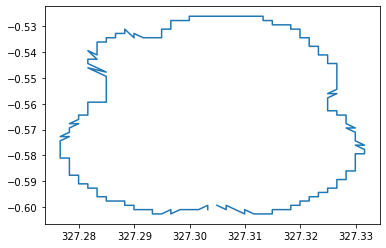

In [49]:
center = edge.mean(axis=1)
dif = edge.transpose() - center
dif1 = dif[dif[:,0]>=0,:]
dif2 = dif[dif[:,0]<0,:]
tan1 = dif1[:,1]/dif1[:,0]
tan2 = dif2[:,1]/dif2[:,0]
angle1 = np.arctan(tan1)
angle2 = np.arctan(tan2)
order1 = np.argsort(angle1)
order2 = np.argsort(angle2)
edge_order = np.concatenate((dif1[order1],dif2[order2]))+center
plt.plot(edge_order[:,0],edge_order[:,1])

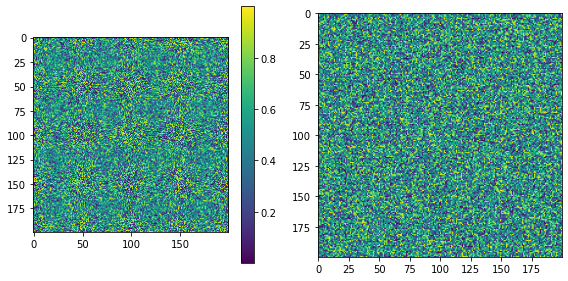

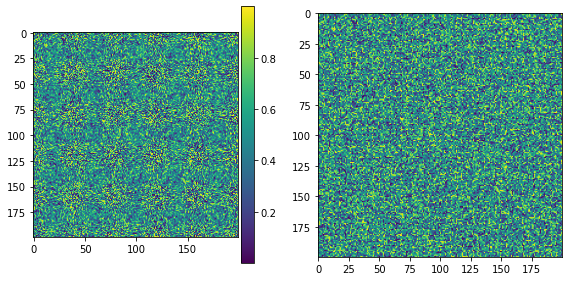

In [25]:
np.random.seed(50)
dados = np.random.random([200,200])
fig,[ax0,ax1] = plt.subplots(1,2,figsize=(8,4))
im = ax0.imshow(dados)
ax1.imshow(dados)
cbar = plt.colorbar(im,ax=ax0)
fig.tight_layout()
plt.show()

fig,[ax0,ax1] = plt.subplots(1,2,figsize=(8,4))
im = ax0.imshow(dados)
ax1.imshow(dados)
cbar = plt.colorbar(im,ax=ax0,pad=0.01)
fig.tight_layout()
plt.show()

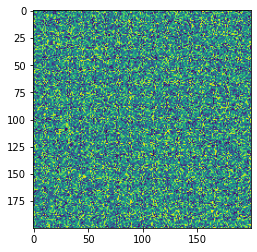

In [11]:
plt.imshow(dados)

In [ ]:
dados = np.random.random